In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
url = 'https://raw.githubusercontent.com/AmbujaBudakoti27/Sarcasm-Detection/main/Sarcasm_Headlines_Dataset.json'
df=pd.read_json(url,lines=True)

In [4]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [6]:
df['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

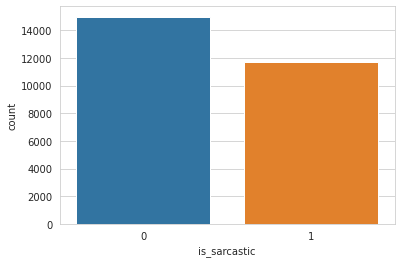

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='is_sarcastic',data=df)

In [10]:
df['headline']=df['headline'].str.replace('@USER', "") 
df['headline']=df['headline'].str.replace('\d+', '')
df['headline']=df['headline'].str.lower()
df['headline']=df['headline'].str.replace('[^\w\s]','')

df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret bl...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the roseanne revival catches up to our thorny ...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear sons web series closest t...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner just wants wife to listen not come up ...,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wishes snape happy birthday in the ...,0


In [11]:
X=df['headline'].values
y=df['is_sarcastic'].values

In [13]:
y = pd.get_dummies(df['is_sarcastic'])
y = y.iloc[:,1].values
y

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
vocab_size=10000
embedding_dim=16
max_length=32
trunc_type='post'
padding_type='post'
oov_tok='<oov>'

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer= Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index=tokenizer.word_index

training_sequences=tokenizer.texts_to_sequences(X_train)
training_padded=pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences=tokenizer.texts_to_sequences(X_test)
testing_padded=pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
training_padded

array([[  46,    1, 4927, ...,    0,    0,    0],
       [8929,  183,  635, ...,    0,    0,    0],
       [6989, 1493, 4928, ...,    0,    0,    0],
       ...,
       [   1,  605,  246, ...,    0,    0,    0],
       [  20, 7641, 1288, ...,    0,    0,    0],
       [2060, 2536, 1246, ...,    0,    0,    0]], dtype=int32)

In [18]:
print(training_padded.shape)
print(testing_padded.shape)

(21367, 32)
(5342, 32)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten

In [20]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())

model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            160000    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.fit(x=training_padded, y=y_train, batch_size=256, epochs=100, validation_data=(testing_padded, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
84/84 [==============================] - 2s 8ms/step - loss: 0.6911 - accuracy: 0.5362 - val_loss: 0.6886 - val_accuracy: 0.5636
Epoch 2/100
84/84 [==============================] - 1s 6ms/step - loss: 0.6890 - accuracy: 0.5516 - val_loss: 0.6865 - val_accuracy: 0.5629
Epoch 3/100
84/84 [==============================] - 1s 6ms/step - loss: 0.6870 - accuracy: 0.5553 - val_loss: 0.6850 - val_accuracy: 0.5629
Epoch 4/100
84/84 [==============================] - 1s 6ms/step - loss: 0.6855 - accuracy: 0.5604 - val_loss: 0.6830 - val_accuracy: 0.5650
Epoch 5/100
84/84 [==============================] - 1s 6ms/step - loss: 0.6833 - accuracy: 0.5627 - val_loss: 0.6796 - val_accuracy: 0.5698
Epoch 6/100
84/84 [==============================] - 1s 6ms/step - loss: 0.6793 - accuracy: 0.5715 - val_loss: 0.6736 - val_accuracy: 0.5863
Epoch 7/100
84/84 [==============================] - 1s 6ms/step - loss: 0.6682 - accuracy: 0.6052 - val_loss: 0.6532 - val_accuracy: 0.6668
Epoch 8/100
8

In [24]:
df_m=pd.DataFrame(model.history.history)
df_m['Epoch']=range(1,31)
df_m.index=df_m['Epoch']
df_m

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.691132,0.536154,0.688647,0.563647,1
2,0.688986,0.551598,0.686467,0.562898,2
3,0.687049,0.555342,0.684984,0.562898,3
4,0.685535,0.560397,0.683041,0.564957,4
5,0.683251,0.562690,0.679644,0.569824,5
6,0.679313,0.571536,0.673627,0.586297,6
7,0.668171,0.605232,0.653204,0.666791,7
8,0.645175,0.657790,0.618963,0.755148,8
9,0.610298,0.703094,0.575098,0.801947,9


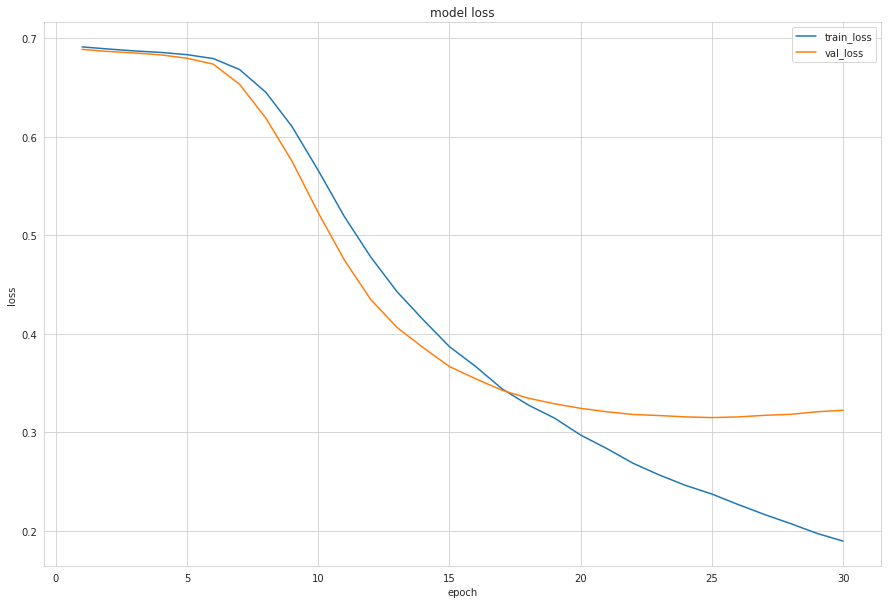

In [32]:
#Loss Graph(Training and Validation)
fig= plt.figure(figsize=(15,10))

plt.plot(df_m['loss'])
plt.plot(df_m['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

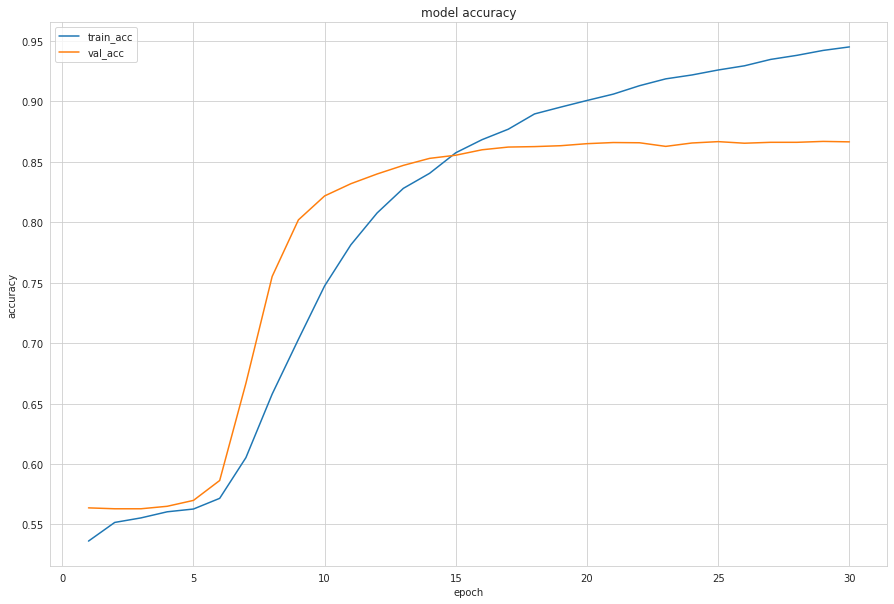

In [33]:
fig= plt.figure(figsize=(15,10))

plt.plot(df_m['accuracy'])
plt.plot(df_m['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()